# WBC Quality control

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("../..")
from common import *

In [3]:
from ehv.core import plot_gate_zarr, plot_gate_zarr_channels

In [4]:
import time
import math
import pyarrow.parquet as pq
from scip.masking import threshold
from scip.masking import util
from scip.features import texture
import zarr

## Load processed frame

In [5]:
try:
    df = pq.read_table(snakemake.input[0]).to_pandas()
    
    if "image_root" in snakemake.config:
        image_root = Path(snakemake.config["image_root"])
        df["meta_path"] = df["meta_path"].apply(lambda p: image_root.joinpath(*Path(p).parts[Path(p).parts.index("images")+1:]))

    output_index = snakemake.output.index
    output_cols = snakemake.output.columns
except NameError:
    data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/scip/20220713131400/")
    data_dir = Path("/home/maximl/scratch/data/vsc/datasets/wbc/scip/20220713131400/")
    df = pq.read_table(data_dir / "features.parquet").to_pandas()
    output_index = data_dir / "indices/index.npy"
    output_cols = data_dir / "indices/columns.npy"

## No bounding box

In [12]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(235780, 4337)

# Number of identified regions per channel 

/apps/gent/RHEL8/zen2-ib/software/SciPy-bundle/2021.10-foss-2021b/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


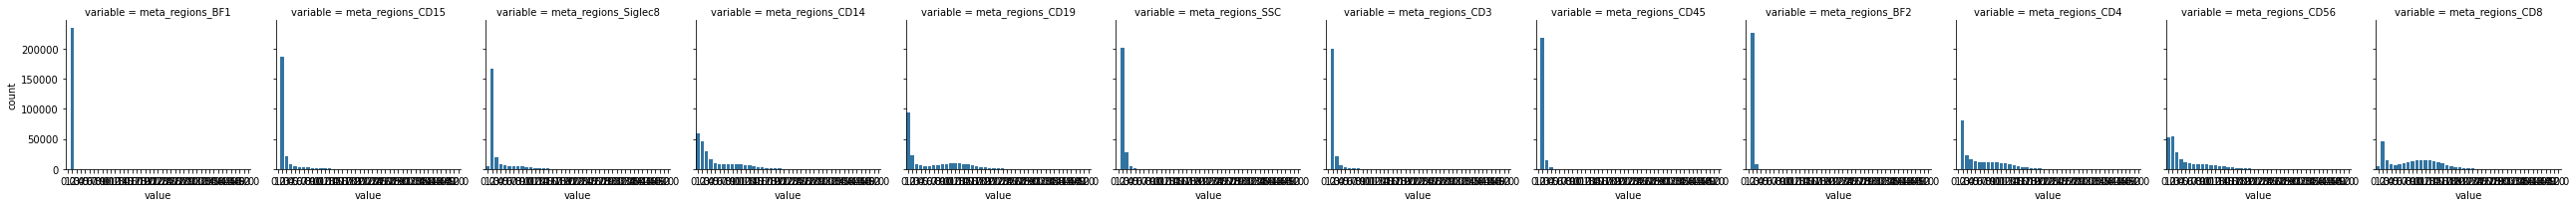

In [15]:
tmp = pandas.melt(df, value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable")
grid.map_dataframe(seaborn.countplot, x="value")

In [16]:
sel = ((df["meta_regions_BF1"] == 1) & (df["meta_regions_BF2"] == 1))

In [17]:
df = df[sel]
df.shape

(227206, 4338)

# NaN values

In [18]:
# show all NaN columns
df.columns[df.isna().all(axis=0)]

Index([], dtype='object')

# All cells must have strictly positive SSC and BF area

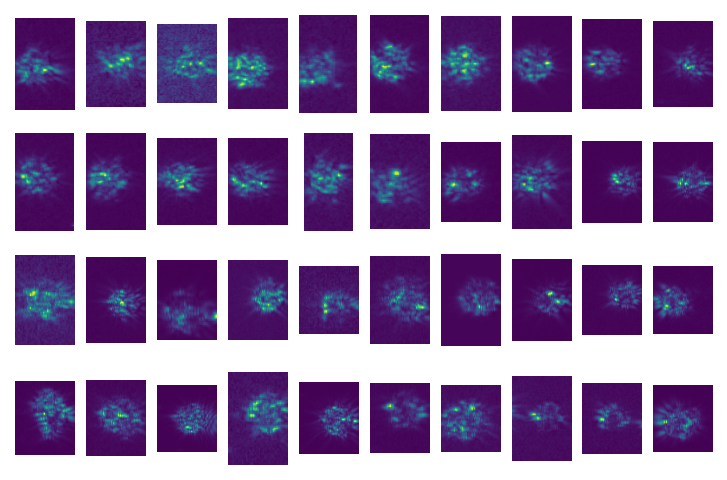

In [19]:
sel1 = df["feat_threshold_area_SSC"] == 0
core.plot_gate_zarr(sel1, df, channel=5, maxn=40)

In [20]:
df = df[~sel1]
df.shape

(225460, 4338)

In [21]:
sel1 = df["feat_threshold_area_BF1"] == 0
if sum(sel1) > 0:
    core.plot_gate_zarr(sel1, df, channel=0, maxn=40)

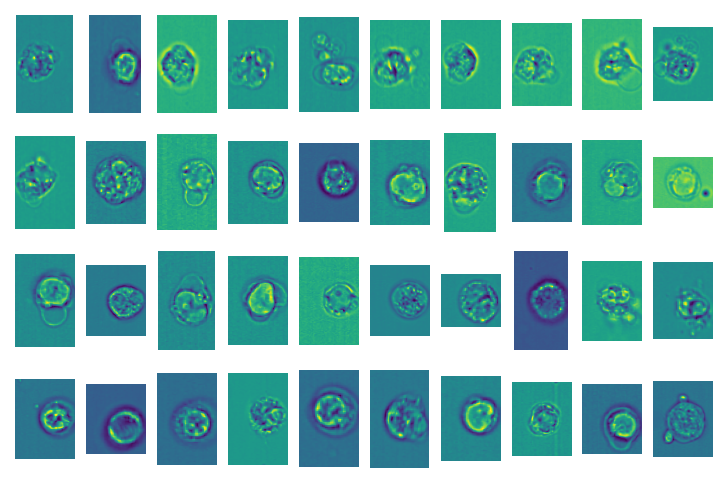

In [22]:
sel1 = df["feat_threshold_area_BF2"] == 0
if sum(sel1) > 0:
    core.plot_gate_zarr(sel1, df, channel=0, maxn=40)

In [23]:
df = df[~sel1]
df.shape

(224903, 4338)

# Detecting multiplets that are missed during segmentation

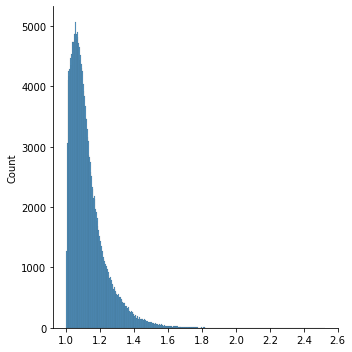

In [26]:
feat_majorminor_ratio = df["feat_threshold_major_axis_length_BF1"] / df["feat_threshold_minor_axis_length_BF1"]
ax = seaborn.displot(data=feat_majorminor_ratio)

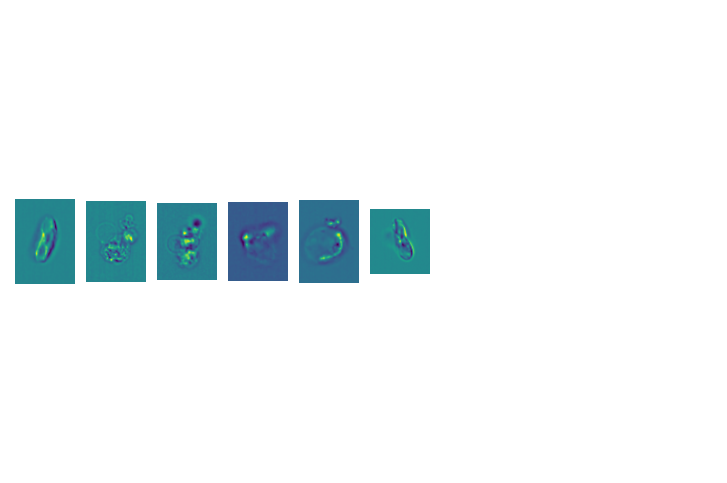

In [27]:
sel1 = feat_majorminor_ratio > 2
plot_gate_zarr(sel1, df)

In [28]:
df = df[~sel1]
df.shape

(224897, 4338)

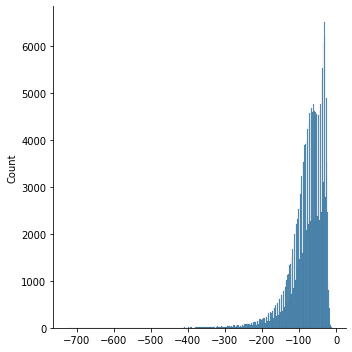

In [29]:
seaborn.displot(data=df["feat_threshold_area_BF1"] - df["feat_threshold_convex_area_BF1"])

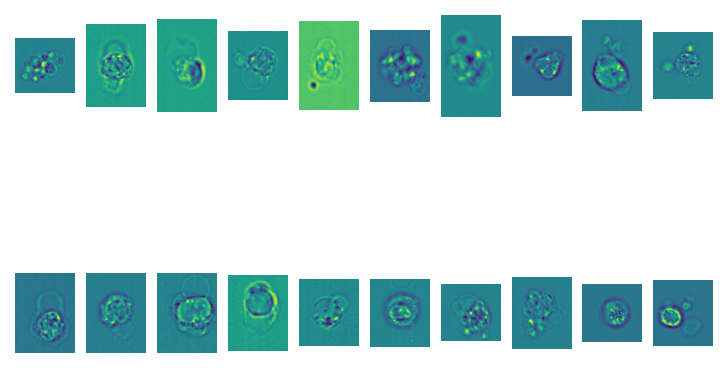

In [31]:
sel1 = (df["feat_threshold_area_BF1"] - df["feat_threshold_convex_area_BF1"]) < -200
core.plot_gate_zarr(sel1, df, maxn=20)

In [32]:
df = df[~sel1]
df.shape

(219957, 4338)

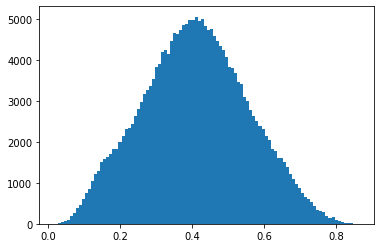

In [34]:
plt.hist(df["feat_threshold_eccentricity_BF1"], bins=100);

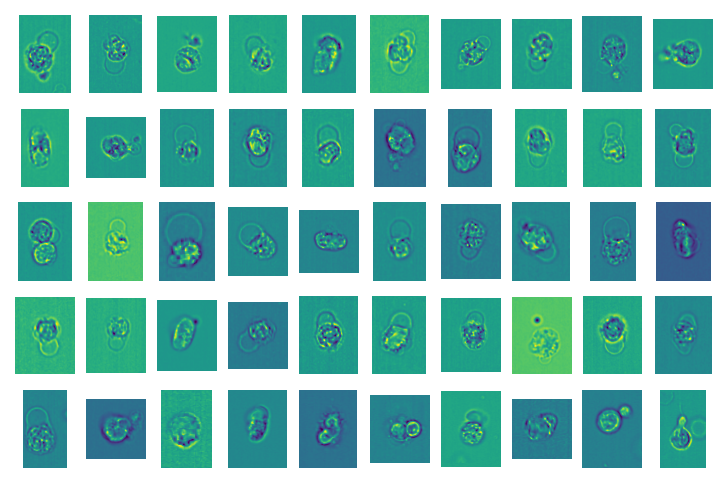

In [37]:
sel1 = df["feat_threshold_eccentricity_BF1"] > 0.75
core.plot_gate_zarr(sel1, df, maxn=50)

In [38]:
df = df[~sel1]
df.shape

(218404, 4338)

# Identifying zero-variance features

In [45]:
low_var = df.filter(regex="feat").columns[df.filter(regex="feat").var() < 0.001]

In [84]:
len(low_var)

415

In [85]:
df = df.drop(columns=low_var)

# Export

In [87]:
numpy.save(output_index, df.index.values)

In [88]:
numpy.save(output_cols, df.columns.values)